In [1]:
%matplotlib inline

In [175]:
import numpy as np
from scipy.integrate import cumtrapz
from scipy.special import lambertw
from scipy.special import gammaln
import matplotlib.pylab as plt
import os
import pymc as pm
import time
#run if missing: conda install pymc

class AttributeDict(dict):
    #extend dictionary object to set atributes as for Matlab objects.
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

class topologies_and_genes:
    def __init__(self):
        """
        Documentation: This is the master class for computing transition, marker genes and topologies
        """
        self.times=[]
        pass
    def set_data(self,tfdata,idxs,labs,iunique):
        """
        inputs:
        #tfdata --> log-transformed data. rows = genes. columns = replicates (several per cell type). 
        #idxs --> which cell types are we interested in out of all of the cell types in tfdata?
        #labs --> cell type names
        #iunique --> what is the cell type identity of each column of tfdata?
        #iunique has same length as the # of columns in tfdata, and the max value
        #of iunique is the number of cell types.
        """
        self.tfdata = tfdata
        self.idxs = idxs
        self.labs = labs
        self.iunique = iunique
    def start_Sibilant(self):
        """
        #compute integrals and calculate topologies
        #inputs grabed from self (after running self.set_data)
        #tfdata --> log-transformed data. rows = genes. columns = replicates (several per cell type). 
        #idxs --> which cell types are we interested in out of all of the cell types in tfdata?
        #labs --> cell type names
        #iunique --> what is the cell type identity of each column of tfdata?
        #iunique has same length as the # of columns in tfdata, and the max value
        #of iunique is the number of cell types.
        """
        
        print('Sibilant started.')
        #get data from self
        tfdata = self.tfdata
        idxs = self.idxs
        labs = self.labs
        iunique = self.iunique
        
        if not hasattr(self,'Params'):
            Params = self.get_parameters()
            self.Params = Params
        else:
            Params = self.Params

        loggenemeans, loggenestds = self.calc_log_mean_std(tfdata, iunique,Params.dist)
        # internalize
        self.loggenemeans,self.loggenestds = loggenemeans, loggenestds

        #the function calc_log_mean_std has been modified to be able to calculate
        #sigma and mu in ZIP distribution. However, these values will be used only
        #if kde is on or filter gene by expression is on. 
        #######verified up to here
        print('Beginning integration.')
        Integrals, best_mu, best_sigma,combinations = self.calculate_integrals(tfdata, idxs, iunique, Params)
        #internalize
        self.Integrals,self.best_mu,self.best_sigma,self.combinations = Integrals, best_mu, best_sigma,combinations

        #combiantions contains all possible combinations of 3

        ncells = len(idxs)
        ngenes = tfdata.shape[0]

        #ncandid = # of likely topologies
        #tlikely = most likely root of the triplet
        #plikely = probability of T being the root

        # Initialize holders
        ncombinations = len(combinations)
        ncandid = np.zeros(ncombinations,dtype=int);
        tlikely = np.zeros(ncombinations,dtype=int);
        plikely = np.zeros(ncombinations);
        pT_g_sum = np.zeros([ncombinations,5]);

        makeplot = Params.get('makeplot',False)#make plots? specify in Params and default to false
        plot_dir = Params.get('plot_dir',None) #save plots somewhere if in Paramas, default to not save
        #find most likely topologies for each triplet

        # Add some progress reporting
        print('Starting trajectories.')   
        for j in range(ncombinations):
            icomb = j
            iii = combinations[icomb,:]
            trip_data = loggenemeans[:,idxs[iii]]
            tlikely_ind, plikely_ind, ncandidates, pT_g_sum_j = self.process_one_triplet(icomb, Integrals, Params, trip_data, makeplot=makeplot, plot_dir=plot_dir, labs=labs[iii]);
            tlikely[j] = tlikely_ind
            plikely[j] = plikely_ind
            ncandid[j] = ncandidates
            pT_g_sum[j,:] = pT_g_sum_j
        #internalize
        self.ncandid,self.tlikely,self.plikely,self.pT_g_sum = ncandid,tlikely,plikely,pT_g_sum

        print('Starting gene selection.')
        #find union of marker and transition genes over all triplets
        good_genes = np.zeros(ngenes)
        good_marker = np.zeros(ngenes)
        good_transition = np.zeros(ngenes)
        transition_probs = np.zeros([ngenes, ncombinations])
        marker_probs = np.zeros([ngenes, 3, ncombinations])
        for i in range(ncombinations):
            if plikely[i]>Params.plikely_thresh and ncandid[i]>=1:
                icomb = i
                iii = combinations[icomb,:]
                trip_data = loggenemeans[:,idxs[iii]]
                prob_asym_topol, prob_marker_topol = self.calculate_gene_probabilities(icomb,Integrals, Params,trip_data,tlikely[icomb]);
                transition_probs[:,i] = prob_asym_topol
                marker_probs[:,:,i] = prob_marker_topol
                genestatus = self.find_classes(prob_asym_topol, prob_marker_topol, tlikely[icomb], trip_data, Params)
                good_genes = (good_genes + abs(genestatus))>0
                good_marker = (good_marker + 1*(abs(genestatus)==3))>0
                good_marker = (good_marker + 1*(abs(genestatus)==2))>0
                good_transition = (good_transition + 1*(abs(genestatus)==1))>0
        self.good_genes,self.transition_probs,self.marker_probs = good_genes,transition_probs,marker_probs
        self.good_transition = good_transition
        self.good_marker = good_marker
    def find_classes(self,pasym_gi_T, pmar_gi_T, tlik, data, Params):
        """
        Documentation...
        """
        N_thresh_asym = Params.N_thresh_asym; 
        N_thresh_sym = Params.N_thresh_sym; 
        p_thresh_asym = Params.p_thresh_asym;
        p_thresh_sym = Params.p_thresh_sym;
        ngenes = pasym_gi_T.shape[0]
        status = np.zeros(ngenes)
        # asym
        asymgenes = np.where(pasym_gi_T > p_thresh_asym)[0] #find genes with prob(beta_i | g_i, T) > p_thresh_asym
        asym_order = np.argsort(pasym_gi_T[asymgenes])[::-1]
        asymgenes = asymgenes[asym_order[:min(N_thresh_asym,len(asymgenes))]]#keep top N_thresh_asym of these genes
        ind_notlik = np.setdiff1d(range(3),tlik)
        # self.asymgenes,self.data,self.ind_notlik = asymgenes,data,ind_notlik
        group = np.argmax(data[asymgenes,:][:,ind_notlik],axis=1)
        status[asymgenes[group==0]] = 1 #mark status in output vector: +/- 1
        status[asymgenes[group==1]] = -1 #mark status in output vector: +/- 1

        #markers for root cell type
        psym_gi_T = pmar_gi_T[:,tlik]
        symgenes = np.where(psym_gi_T > p_thresh_sym)[0] #find genes with prob(alpha_i = 1| g_i, T) > p_thresh_sym
        sym_order = np.argsort(psym_gi_T[symgenes])[::-1]
        symgenes = symgenes[sym_order[:min(N_thresh_sym,len(symgenes))]]#keep top N_thresh_sym of these genes
        status[symgenes] = 2; #mark status in output vector: +2

        # markers for leaf cell types
        daught = np.setdiff1d(range(3),tlik)
        daught1 = daught[0] # code: +3
        daught2 = daught[1] # code: -3
        markergenes1 = np.where(pmar_gi_T[:,daught1] > p_thresh_sym)[0] #find genes with prob(alpha_i = 1| g_i, T) > p_thresh_sym
        markergenes2 = np.where(pmar_gi_T[:,daught2] > p_thresh_sym)[0] #find genes with prob(alpha_i = 1| g_i, T) > p_thresh_sym
        mar1_order = np.argsort(pmar_gi_T[markergenes1, daught1])[::-1]
        mar2_order = np.argsort(pmar_gi_T[markergenes2, daught2])[::-1]
        markergenes1 = markergenes1[mar1_order[:min(N_thresh_sym,len(markergenes1))]]#keep top N_thresh_sym of these genes
        markergenes2 = markergenes2[mar2_order[:min(N_thresh_sym,len(markergenes2))]]#keep top N_thresh_sym of these genes
        status[markergenes1] = 3;
        status[markergenes2] = -3;

        return status
    def calculate_gene_probabilities(self,icomb,Integrals, Params,trip_data,tlik):
        """
        Documentation:
        #See Equations (27) and (28)
        """
        odds0 = Params.odds0
        psla = Params.psla
        pgi_mas_T, pgi_sla, pgi_sym = self.calc_pgi_topo(icomb,Integrals, Params, trip_data,tag = 'calculate_gene_probabilities') #get probability of data given different hypotheses
        # transition genes
        odds_asym_topol = odds0*pgi_mas_T[:,tlik]/pgi_sla; # p(beta_i = 1 | g_i, T)/p(beta_i = 0 | g_i, T)
        inf_ind = np.isinf(odds_asym_topol) #if pgi_sla==0, odds_asym_topol should be corrected to 1 instead of 0
        prob_asym_topol = odds_asym_topol/(1.+odds_asym_topol); # p(beta_i = 1 | g_i, T)
        prob_asym_topol[inf_ind] = 1 #correct for the case where p(g_i | beta_i=0)=0
        prob_asym_topol[np.isnan(prob_asym_topol)] = 0  #get rid of NaNs  

        p_mas = odds0/(1.+odds0) # prior p(beta_i=1)
        p_sla = 1./(1.+odds0) # prior p(beta_i=0)
        pg_T = p_mas*pgi_mas_T[:,tlik] + p_sla*pgi_sla; # p(g_i | T)

        #markers
        #pg_T as above
        prob_marker_topol = np.zeros(pgi_sym.shape)
        for t in range(3):#1:3
            psym = pgi_sym[:,t] # p(g_i | T, gene i marker for cell type t) i.e. p(g_i | T, beta_i = 0, alpha_i = 1)
            pnotsym = pg_T-p_sla*psla[t+1]*psym; # p(g_i | T, gene i NOT marker for cell type t). psla(tlik+1) is p(mu_A > mu_BC | b_i = 0) (or equiv) 
            prior_sym_odds = (p_sla*psla[t+1])/(1-p_sla*psla[t+1]); # p(alpha_i = 1 for cell type t)/p(alpha_i = 0 for cell type t);
            odds_marker_topol = prior_sym_odds*psym/pnotsym; # p(alpha_i = 1 | g_i, T)/p(alpha_i = 0 | g_i, T)
            prob_marker_topol[:,t] = odds_marker_topol/(odds_marker_topol+1.); # p(alpha_i = 1 for cell type t | g_i, T)
            #deal with nonsense
            prob_marker_topol[odds_marker_topol == np.inf,t] = 1 ## This can never reach inf. changing because think it's providing spurious markers
            prob_marker_topol[np.isnan(prob_marker_topol[:,t]),t] = 0 ## changing because think it's providing spurious markers
        return prob_asym_topol, prob_marker_topol
    def process_one_triplet(self,icomb, Integrals, Params, tripdata, makeplot=False, plot_dir=None, labs=['x','y','z']):
        """
        Documentation:
        Calls: calc_pgi_topo with tag process_one_triplet
        """
        allodds = Params.oddsrange
        topology_prior = Params.topology_prior
        plikely_thresh = Params.plikely_thresh
        #find p(g_i|T,b_i) for each gene starting from integrals
        pgi_mas_T, pgi_sla, _ = self.calc_pgi_topo(icomb,Integrals, Params, tripdata,tag='process_one_triplet')

        pT_g = np.zeros([len(allodds),4]) #pT_g as a function of prior odds
        odds_mas_sla_T = pgi_mas_T/np.expand_dims(pgi_sla,-1) # See Equation (18)
        #deal with nonsense
        odds_mas_sla_T[np.isnan(odds_mas_sla_T)] = 1 #set nans to 1
        odds_mas_sla_T[odds_mas_sla_T==np.inf] = 1 #set infs to 1
        for i in range(len(allodds)):
            prior_odds = allodds[i] #p(beta_i = 1)/p(beta_i = 0) Equation (21)
            odds = 1+ prior_odds*odds_mas_sla_T
            sum_log_odds = np.sum(np.log(odds),axis=0)
            prododds = np.exp(sum_log_odds - np.max(sum_log_odds)) #divide by max(prod(odds)) to avoid Inf
            pT_g[i,:] = prododds*topology_prior/np.sum(topology_prior*prododds); # this is Equation (20)
        
        self.odds_mas_sla_T = odds_mas_sla_T
        self.pT_g = pT_g
        
        greaterthan0 = pT_g[:,:3] > plikely_thresh
        ncandidates = np.sum(np.sum(greaterthan0,axis=0)>0); #how many topologies have probability greater than plikely_thresh
        #ncandicates is a number in [0,1,2,3]

        #find likely topology
        tlikely_ind, plikely_ind, report_ind = self.find_Tlikely(pT_g, icomb)
        self.report_ind = report_ind
        self.tlikely_ind = tlikely_ind
        # Report the best odds for a triplet
        pT_g_max = np.concatenate([[allodds[report_ind]],pT_g[report_ind,:]])

        if makeplot:
            ###Not tested 
            #make a dot plot

            pgi_mas_Tmin = np.column_stack([3*Integrals.IABC_Amin[:,icomb],3*Integrals.IABC_Bmin[:,icomb],3*Integrals.IABC_Cmin[:,icomb]])#find p(g_i | b_i=1, cell T is min)
            imax = np.argmax(pgi_mas_Tmin,axis = -1); #find cell type that gene i votes against
            f=plt.figure(figsize=(15,15))
            plt.semilogx(odds_mas_sla_T,4-imax,'o')
            #plot boundaries
            plt.xlim([1e-10,10*np.max(allodds)])
            plt.ylim([0,4])
            #weird labels
            plt.yticks(range(1,4), [labs[i_lab] for i_lab in [2,1,0]])
            if plot_dir is not None:
                f.savefig(plot_dir+os.sep+'topvotes-'+str(icomb)+'.png')
                plt.close(f)
            else:
                plt.show()

            #plot p(T|{g}) as a function of p(b_i=1)/p(b_i=0)
            f = plt.figure(figsize=(15,15));
            plt.semilogx(allodds, pT_g, '-'); 
            #legend(labs{1},labs{2},labs{3},'null', 'Location', 'northwest'); 
            plt.xlim([np.min(allodds),np.max(allodds)])
            plt.ylim([-0.05,1.05])
            if plot_dir is not None:
                f.savefig(plot_dir+os.sep+'pT_g-'+str(icomb)+'.png')
                plt.close(f)
            else:
                plt.show()
        return tlikely_ind, plikely_ind, ncandidates, pT_g_max
    def find_Tlikely(self,pT_g, triplet):
        """
        Finds the most likely topology of triplet given pT_g(odds_prior,Topology)
        tlikely_ind - most likely Topology 4-null 
        plikely_ind - maximum probability for that topology
        report_ind - index of mostlikely odd
        """
        m = np.max(pT_g,axis=-1)
        itmax = np.argmax(pT_g,axis=-1) #find most likely topology for each of the odds

        #this is not a fair treatment of topologies
        ## if any of the non-nul topologies have a maximum for some odd then exclude nulltopology
        itmaxnot4 = itmax!=3#bool not null topology across odds
        if np.sum(itmaxnot4)!=0:
             m[itmaxnot4==False]=-np.inf # set all null topology values to - infinity

        report_ind = np.argmax(m)
        tlikely_ind  = itmax[report_ind] #ensures the convention null topology is 4
        #tlikely_ind  = (itmax[report_ind]+1)%4 #ensures the convention null topology is 0
        plikely_ind = np.max(m)

        return tlikely_ind, plikely_ind, report_ind
    def calc_pgi_topo(self,icomb,Integrals, Params, data,tag=''):
        """
        Documentation...
        This appears in 2 files: , identical forms but the filter_min condition is different.
        process_one_triplet.m,calculate_gene_probabilities.m
        Currently the process_one_triplet.m is implemented
        """
        log_asym_min = Params.log_asym_min
        log_sym_min = Params.log_sym_min
        filter_min = Params.filter_min
        psla = Params.psla

        pgi_sla_1 = Integrals.IABCsame[:,icomb] #p(gi | alpha_i = 0, beta_i = 0) (Equation 9)
        pgi_sla_2Amax = 2*Integrals.IA_BC_Amax[:,icomb] 
        pgi_sla_2Amax[pgi_sla_2Amax<0.] = 0. #(this is unlikely: should all be > 0 but I did find one floating point error)
        pgi_sla_2Bmax = 2*Integrals.IA_BC_Bmax[:,icomb]
        pgi_sla_2Bmax[pgi_sla_2Bmax<0.] = 0.
        pgi_sla_2Cmax = 2*Integrals.IA_BC_Cmax[:,icomb]
        pgi_sla_2Cmax[pgi_sla_2Cmax<0.] = 0. #p(gi | alpha_i = 1, beta_i = 0) Equation (8)
        
        #internalize for troubleshooting:
        self.pgi_sla_1 = pgi_sla_1
        
        pgi_sym = np.column_stack([pgi_sla_2Amax,pgi_sla_2Bmax,pgi_sla_2Cmax])
        self.pgi_sym=pgi_sym

        pgi_mas_Tmin = 3.*np.column_stack([Integrals.IABC_Amin[:,icomb],Integrals.IABC_Bmin[:,icomb],Integrals.IABC_Cmin[:,icomb]]) #p(gi | beta_i = 1, cell type T is a leaf)
        pgi_mas_T = (1./2.)*np.column_stack([pgi_mas_Tmin[:,1]+pgi_mas_Tmin[:,2],
                                             pgi_mas_Tmin[:,0]+pgi_mas_Tmin[:,2],
                                             pgi_mas_Tmin[:,1]+pgi_mas_Tmin[:,0]]); #p(gi | beta_i = 1, topology T) Equation (4)
        pgi_sla = psla[0]*pgi_sla_1 + psla[1]*pgi_sla_2Amax + psla[2]*pgi_sla_2Bmax + psla[3]*pgi_sla_2Cmax; # p(g_i | beta_i = 0) See Equation (14)
        self.pgi_sla=pgi_sla

        if filter_min: #some additional coarse filtering if option chosen
            expressed = data>log_asym_min
            sym_expressed = data>log_sym_min
            pgi_mas_T = pgi_mas_T*expressed*((np.expand_dims(np.sum(expressed,axis=1)>1,-1))*np.ones([1,3])) #transition genes above expression threshold in at least 2 cell types
            pgi_sym = pgi_sym*sym_expressed #marker genes above expression threshold "marked" cell type
            if tag=='calculate_gene_probabilities':
                imax = np.argmax(data,axis=-1)
                for t in range(3):
                    pgi_sym[:,t] = pgi_sym[:,t]*(imax==t); #marker gene most highly expressed in "marked" cell type
            
        pgi_mas_0 = (1./3.)*np.sum(pgi_mas_T,axis=1) #p(g_i | b_i = 1, T = null) Equation (6), Equation (7)
        pgi_mas_T = np.column_stack([pgi_mas_T,pgi_mas_0]) #p(g_i | b_i = 1, T)
        self.pgi_mas_T = pgi_mas_T
        self.Integrals = Integrals
        return pgi_mas_T, pgi_sla, pgi_sym
    def calculate_integrals_one_gene(self,g_dist, i, ncells, combinations, log2tfdata, 
                                 iunique, idxs, P, M, S, logS, lM, lS, firstcut, dm, ds,normed=True):
        ncombinations = len(combinations)
        tempIA = np.zeros([1,ncells])
        tempIAB = np.zeros([ncells,ncells,1])
        tempIABCsame = np.zeros([1, ncombinations])
        tempIA_BC_Amax = np.zeros([1, ncombinations])
        tempIA_BC_Bmax = np.zeros([1, ncombinations])
        tempIA_BC_Cmax = np.zeros([1, ncombinations])
        tempIABC_Amin = np.zeros([1, ncombinations])
        tempIABC_Bmin = np.zeros([1, ncombinations])
        tempIABC_Cmin = np.zeros([1, ncombinations])
        Isigma = np.zeros(ncells,dtype=object); #pre-allocate vector for integration over sigma for one cell type
        Isigma2 = np.zeros([ncells,ncells],dtype=object); #pre-allocate matrix for integration over sigma for two cell types
        diags = np.zeros([ncells,ncells],dtype=object); #pre-allocate cell for integration over mu for two cell types
        data = log2tfdata[i,:]; #vector of gene(i) expression levels in all cells

        best_mu_gene = np.zeros(ncells); #pre-allocate vector for the parameters that give the highest likely hood for each gene in each cell type
        best_sigma_gene = np.zeros(ncells);
        for j in range(ncells): #for each cell cluster j
            #N1 = sum(iunique==idxs(j));#integrals over one cell type (to use in integrals for Equation 9)
            xk1 = data[iunique==idxs[j]] #gene(i) expression levels in all cells in cluster j

            F1 = self.logDa(g_dist,M,S,xk1,logS); #returns a sbin by mbin matrix of logDa(gi|mu,sigma) for gene(i) in cluster j. See equation (11) (or the equivalent for ZIP).
            # Save most likely distribution for each gene, per cluster.
            i1,i2 = np.unravel_index(np.argmax(F1),F1.shape)
            best_mu_gene[j],best_sigma_gene[j]= M[0,i2],S[i1,0]
            #if normed: F1-=np.max(F1) ##normalize
            F1 = np.exp(F1)
            F1 = P*F1  # multiply by prior, but flat.
            F1[np.isnan(F1)] = 0 # correct for NaN?

            self.F1=F1#internalize for troubleshooting

            tempIA[0,j] = dm*ds*np.trapz(np.trapz(F1,axis=0),axis=0); #integrate Da over all prior mu and sigma for gene(i) in cluster j. Can be used in Eq.7 for T=0.
            #if normed: F1 = F1/tempIA[0,j]
            if g_dist == 'N':
                Isigma[j] = ds*np.trapz(F1,axis=0);#store integrals over sigma for use later. Isigma{j} is a vector of length mbins.
            elif g_dist =='P': #if dist=P, integrate sigma last
                Isigma[j] = F1
            for k in range(j+1,ncells):#integrals over 2 cell types (to use in integrals for Equation 9)
                #N2 = sum(iunique==idxs(k)); N12 = N1+N2;
                xk2 = data[iunique==idxs[k]]#(ismember(iunique,idxs(k)));
                xk12 = np.concatenate([xk1,xk2])
                F2 = self.logDa(g_dist,M,S,xk12,logS)
                #if normed: F2-=np.max(F2) ##normalize
                F2 = np.exp(F2)
                F2 = P*F2  # multiply by prior, but flat.
                F2[np.isnan(F2)] = 0 # correct for NaN?
                tempIAB[j,k,0] = dm*ds*np.trapz(np.trapz(F2,axis=0),axis=0); #integrate Da over the hyperprior space for gene(i) in cluster j+k.
                tempIAB[k,j,0] = tempIAB[j,k,0]; #tempIAB is a symmetric 3by3 matrix.
                #if normed: F2 = F2/tempIAB[j,k,0]
                if g_dist == 'N':
                    Isigma2[j,k] = ds*np.trapz(F2,axis=0); #Isigma2 is a symmetric 3by3 cell.
                elif g_dist == 'P': #if dist=P, integrate sigma last
                    Isigma2[j,k] = F2
                Isigma2[k,j] = Isigma2[j,k];
        for j in range(ncells):
            for k in range(j+1,ncells):
                start_ = time.time()
                if g_dist == 'N':
                    Isigmaj,Isigmak = np.meshgrid(Isigma[j],Isigma[k])
                    AB = Isigmaj*Isigmak
                    AB_diag = np.diag(cumtrapz(cumtrapz(AB[::-1,::-1],axis=0),axis=1))[::-1]#AB_diag is a vector of length mbins.
                    #Each element is the integral of [Integral(Dj over sigma)*Integral(Dk over sigma)]
                    #over mu values greater than a certain mu (in the prior space).
                    diagjk = np.array(AB_diag[:])#delete the first element of integration of Dj and Dk over the complete hyperprior space.
                                                 #done internally by cumtrapz in python
                    prev_firstcut = 0 if firstcut==0 else firstcut-1
                    #diagjk[:prev_firstcut] = diagjk[firstcut] 
                    diagjk[:prev_firstcut] = diagjk[prev_firstcut]
                    #replace integrations over mu>mu_replace for mu_replace<mu_cutoff with the integrations over mu>mu_cutoff
                elif g_dist =='P':
                    Isigmaj = np.array(Isigma[j].reshape((1,lS,lM)))
                    Isigmak = np.array(Isigma[k].reshape((1,lS,lM)))
                    Isigmaj_aug = np.transpose(np.repeat(Isigmaj,lM,axis=0),axes=(2,1,0))
                    Isigmak_aug = np.repeat(Isigmak,lM,axis=0)
                    AB = Isigmaj_aug*Isigmak_aug
                    #AB = ds*np.trapz(AB,axis=1)
                    start = time.time()
                    AB_cum = cumtrapz(cumtrapz(AB[::-1,:,::-1],axis=0),axis=2)[::-1,:,::-1]
                    time_ = time.time()-start
                    if not hasattr(self,'times4'):self.times4=[]
                    self.times4.append(time_)
                    AB_diag = AB_cum.diagonal(axis1=0,axis2=2)
                    prev_firstcut = 0 if firstcut==0 else firstcut-1
                    diagjk = np.array(AB_diag)
                    diagjk[:,:prev_firstcut] = np.repeat(diagjk[:,prev_firstcut].reshape(diagjk.shape[0],1),prev_firstcut,axis = 1)
                    #replace integrations over mu>mu_replace for mu_replace<mu_cutoff with the integrations over mu>mu_cutoff
                time_ = time.time()-start_
                if not hasattr(self,'times3'):self.times3=[]
                self.times3.append(time_)
                diags[j,k] = diagjk #diags is a 3by3 symmetric cell with each element being a (mbins-1)by1 vector
                diags[k,j] = diags[j,k]

        for j in range(ncombinations):
            ind123 = np.sum([iunique==idx_ for idx_ in idxs[combinations[j,:]]],axis=0)>0
            xk123 = data[ind123] #computation of integrals over 3 cell types assuming they are from a single distribution
            #N123 = length(xk123);
            F3 = self.logDa(g_dist, M,S,xk123,logS)
            #if normed: F3-=np.max(F3) ##normalize
            F3 = np.exp(F3)
            F3 = P*F3  # multiply by prior, but flat.
            #if normed: F3 = F3/np.sum(F3) ##normalize
            F3[np.isnan(F3)] = 0 # correct for NaN?
            tempIABCsame[0,j] = dm*ds*np.trapz(np.trapz(F3,axis=0),axis=0); # Equation (10). Integration of Da over the entire hyperprior space
            
            #troubleshoot
            self.Isigma=Isigma
            self.diags = diags
            self.Isigma_t = Isigma[combinations[j,0]][:-1]
            self.diags_t = diags[combinations[j,1],combinations[j,2]]
            self.combinations = combinations
            self.j = j
            start = time.time()
            if g_dist == 'N':
                tempIABC_Amin[0,j] = dm*dm*dm*np.trapz(Isigma[combinations[j,0]][:-1]*diags[combinations[j,1],combinations[j,2]]); # Equation (6)
                tempIABC_Bmin[0,j] = dm*dm*dm*np.trapz(Isigma[combinations[j,1]][:-1]*diags[combinations[j,0],combinations[j,2]])# if cutoff=0, this is exactly Equation(6)
                tempIABC_Cmin[0,j] = dm*dm*dm*np.trapz(Isigma[combinations[j,2]][:-1]*diags[combinations[j,0],combinations[j,1]])
            elif g_dist == 'P':
                tempIABC_Amin[0,j] = ds*dm*dm*dm*np.trapz(np.trapz(Isigma[combinations[j,0]][:,:-1]*diags[combinations[j,1],combinations[j,2]],axis=0),axis=0)
                tempIABC_Bmin[0,j] = ds*dm*dm*dm*np.trapz(np.trapz(Isigma[combinations[j,1]][:,:-1]*diags[combinations[j,0],combinations[j,2]],axis=0),axis=0)# if cutoff=0, this is exactly Equation(6)
                tempIABC_Cmin[0,j] = ds*dm*dm*dm*np.trapz(np.trapz(Isigma[combinations[j,2]][:,:-1]*diags[combinations[j,0],combinations[j,1]],axis=0),axis=0)
            time_ = time.time()-start
            if not hasattr(self,'times2'):self.times2=[]
            self.times2.append(time_)
            
            start = time.time()
            if g_dist =='N':
                
                IMesh1,IMesh2 = np.meshgrid(Isigma2[combinations[j,1],combinations[j,2]],Isigma[combinations[j,0]])
                A_BC = IMesh1*IMesh2
                IMesh1,IMesh2 = np.meshgrid(Isigma2[combinations[j,0],combinations[j,2]],Isigma[combinations[j,1]])
                B_AC = IMesh1*IMesh2
                IMesh1,IMesh2 = np.meshgrid(Isigma2[combinations[j,0],combinations[j,1]],Isigma[combinations[j,2]])
                C_AB = IMesh1*IMesh2
            
            elif g_dist =='P':
                
                IMesh1 = np.array(Isigma2[combinations[j,1],combinations[j,2]])
                IMesh2 = np.array(Isigma[combinations[j,0]])
                IMesh1_aug = np.repeat(IMesh1.reshape((1,lS,lM)),lM,axis=0)
                IMesh2_aug = np.repeat(IMesh2.reshape((1,lS,lM)),lM,axis=0)
                IMesh2_aug=np.transpose(IMesh2_aug,axes=(2,1,0))
                A_BC = np.array(IMesh1_aug*IMesh2_aug)
                A_BC = ds*np.trapz(A_BC,axis=1)
                IMesh1 = np.array(Isigma2[combinations[j,0],combinations[j,2]])
                IMesh2 = np.array(Isigma[combinations[j,1]])
                IMesh1_aug = np.repeat(IMesh1.reshape((1,lS,lM)),lM,axis=0)
                IMesh2_aug = np.repeat(IMesh2.reshape((1,lS,lM)),lM,axis=0)
                IMesh2_aug=np.transpose(IMesh2_aug,axes=(2,1,0))
                B_AC = np.array(IMesh1_aug*IMesh2_aug)
                B_AC = ds*np.trapz(B_AC,axis=1)
                IMesh1 = np.array(Isigma2[combinations[j,0],combinations[j,1]])
                IMesh2 = np.array(Isigma[combinations[j,2]])
                IMesh1_aug = np.repeat(IMesh1.reshape((1,lS,lM)),lM,axis=0)
                IMesh2_aug = np.repeat(IMesh2.reshape((1,lS,lM)),lM,axis=0)
                IMesh2_aug=np.transpose(IMesh2_aug,axes=(2,1,0))
                C_AB = np.array(IMesh1_aug*IMesh2_aug)
                C_AB = ds*np.trapz(C_AB,axis=1)
            time_ = time.time()-start
            self.times.append(time_)
            A_BC = np.tril(A_BC,0);
            B_AC = np.tril(B_AC,0);
            C_AB = np.tril(C_AB,0);
            tempIA_BC_Amax[0,j] = dm*dm*np.trapz(np.trapz(A_BC,axis=0),axis=0); # Equation (9) but why tril(X,1) instead of tril(X,0)??
            tempIA_BC_Bmax[0,j] = dm*dm*np.trapz(np.trapz(B_AC,axis=0),axis=0);
            tempIA_BC_Cmax[0,j] = dm*dm*np.trapz(np.trapz(C_AB,axis=0),axis=0);
            
        return [tempIA, tempIAB, tempIABCsame, tempIABC_Amin, tempIABC_Bmin, tempIABC_Cmin, tempIA_BC_Amax, tempIA_BC_Bmax, tempIA_BC_Cmax, best_mu_gene, best_sigma_gene]
    def calc_log_mean_std(self,data,iunique, g_dist):
        """Given:
        # data # an expression array m x n
        # iunique # a vector of cell identies of length n
        # g_dist # a string id for the distribution N - (log)normal distribution, P - ZeroInflatedPoisson (ZIP)
        Returns: 
        means and stds IF g_dist = N
        max_likelihood of means of ZIP and zero probs IF g_dist = P """
        #cast as numpy arrays for easy computations
        data = np.array(data)
        iunique = np.array(iunique)

        cell_types = np.unique(iunique)
        sx,sy = data.shape
        loggenemeans = np.zeros([sx, len(cell_types)])
        loggenestds = np.zeros([sx, len(cell_types)])

        # iterate through cell types
        for i,cell_type in enumerate(cell_types):
            datai= data[:,iunique==cell_type]#data of cell type
            splmean = np.mean(datai,axis=-1)
            splstd = np.std(datai,axis=-1)
            if g_dist == 'N':
                loggenemeans[:,i] = splmean
                loggenestds[:,i] = splstd
            elif g_dist == 'P':
                #maximum likelihood 
                # for lambda we want to solve: xbar (1-exp(-lambda)) = lambda (1-n0/n)
                # https://en.wikipedia.org/wiki/Zero-inflated_model
                # the analytical solution to 1-exp(-x)= b x is: (1+b*lambertw(-np.exp(-1./b)/b))/b
                n0 =np.sum(datai==0,axis=-1)
                n = float(datai.shape[-1])
                b = (1.-n0/float(n))/splmean
                max_likelihood_lambda = ((1.+b*lambertw(-np.exp(-1./b)/b))/b).real
                max_likelihood_pi = 1.-splmean/max_likelihood_lambda
                non_sense_1 = np.isnan(max_likelihood_lambda)&(max_likelihood_pi>1)
                non_sense_2 = max_likelihood_pi<0
                #deal with nonsense
                max_likelihood_lambda[non_sense_1]=splmean[non_sense_1]
                max_likelihood_pi[non_sense_1]=1.
                max_likelihood_lambda[non_sense_2]=splmean[non_sense_2]
                max_likelihood_pi[non_sense_2]=0.
                loggenemeans[:,i] = max_likelihood_lambda
                loggenestds[:,i] = max_likelihood_pi
        return loggenemeans, loggenestds  
    def simulate_ZIP(self,mu_true=12,psi_true=0.5,nx=7,ny=2,dist='P'):
        """Simulates zero inflated poisson
        with mean mu_true, and sigma = 1-psi_true (prob for 0) nx - number of sets, ny is number of observations/set
        """
        # True parameter values
        #mu_true,psi_true,nx,ny = 12,0.5,7,2
        # Simulate some data
        if dist=='P':
            datai = np.array([[pm.rpoisson(mu_true)*(np.random.random()<psi_true) for i in range(ny)] for i_ in range(nx)])
        elif dist == 'N':
            datai = np.array([[pm.rnormal(mu_true, psi_true) for i in range(ny)]for i_ in range(nx)])  
        return datai
    def test_likelihood(self):
        """
        Test logDa function using simulate_ZIP function 
        """
        datai = self.simulate_ZIP(mu_true=35, psi_true=0.5, nx=1, ny=30)
        xk1 = datai[0]
        m = np.linspace(30,40,100)
        s = np.linspace(0.1,0.9,98)
        #s = np.linspace(3,800,100)
        M,S = np.meshgrid(m,s)
        log_vals = self.logDa('P',M,S,xk1,logS=None)
        i1,i2 = np.unravel_index(np.argmax(log_vals),log_vals.shape)
        
        import matplotlib.cm as cm
        import matplotlib.pylab as plt
        plt.figure()
        plt.title('Max likelihood vals:'+str([m[i2],s[i1]]))
        plt.imshow(np.exp(log_vals),interpolation='nearest')
        plt.show()
        plt.figure()
        plt.hist(xk1)
        plt.show()
    def get_parameters(self):
        """
        Sets default paramaters
        """
        Params = AttributeDict()
        #numeric integration parameters
        Params.use_kde = 0; # do NOT turn this on until function is fixed to deal with n=[sbins,mbins]. 1 -> use kde-estimated empirical prior;  0 -> use uniform prior
        Params.use_parallel_integrals = 1; #compute integrals in parallel?
        Params.use_parallel_topology = 0;
        Params.use_parallel_genes = 0;
        Params.use_parallel = any([Params.use_parallel_integrals, Params.use_parallel_topology, Params.use_parallel_genes]);
        Params.parallel_pool_size = 16; #number of processors for parallelization

        Params.dist = 'N'; #distribution for gene expression. Default is 'N' for normal. Can also use 'P' for ZIP.
        Params.mumin = 0; # min and max for mean prior in normal distribution, or for lambda prior in ZIP. 
        Params.mumax = 7;
        Params.sigmin = 0; # min and max for std prior in normal distribution, or for sigma prior in ZIP.
        Params.sigmax = 3;
        Params.mbins = 2**8; #number of bins for numeric integration over distribution parameters
        Params.sbins = 128;

        Params.cutoff = np.log2(10); # expression threshold for numeric integration

        Params.verbose = 2; # 0 = default (no) reporting
                            # 1 = extra results
                            # 2 = debugging
        Params.save_integrals = 1; # save integrals for later dot-plotting
        Params.save_gene_probs = 1; # save gene probabilities for later
        Params.save_best_dists = 1; # save info about 'best' mu and sigma per gene/cluster

        Params.psla = [1./2, 1./6, 1./6, 1./6]; #vector of prior probabilities for non-transition genes
        Params.topology_prior = [1./4, 1./4, 1./4, 1./4]; #topology prior [p(A) p(B) p(C) p(0)]
        Params.plikely_thresh = 0.6; # threshold for probability of topology given data
        Params.filter_min = 0; #ignore genes with values under threshold?
        Params.log_asym_min = np.log2(2); #threshold for transition gene expression
        Params.log_sym_min = np.log2(2); #threshold for marker gene expression
        Params.oddsrange = np.logspace(-4,2,50); #range to vary prior odds p(beta_i = 1)/p(beta_i = 0)

        #parameters for gene probabilities
        Params.N_thresh_sym = 1000; # max number of genes in gene classes
        Params.N_thresh_asym = 1000; 
        Params.p_thresh_asym = 0.8; # probability thresholds for defining gene classes
        Params.p_thresh_sym = 0.8; 
        Params.odds0 = 0.05; # prior transition 
        #do checks
        if Params.dist == 'P':
            if Params.sigmax > 1 or Params.sigmax < 0:
                raise ValueError('Params.sigmax for Zero Inflated Poisson distribution must be in the range [0,1]')
        self.Params=Params
        return Params
    
    def calculate_integrals(self,log2tfdata, idxs, iunique, Params):
        """Given:
        #log2tfdata# expresion matrix of shape m x n
        #idxs# a vector with a subset of values from iunique ...
        #iunique# a 
        This returns:
        [Integrals, best_mu, best_sigma,combinations]
        The integrals used in this paper, the best_mu and best_sigma given data and the combinations matrix used.
        """
        #cast as numpy arrays for easy computation
        log2tfdata = np.array(log2tfdata)
        idxs = np.array(idxs)
        iunique = np.array(iunique)
        #internalize paramaters
        nbins = [Params.sbins, Params.mbins]
        g_dist = Params.dist
        mumin = Params.mumin
        mumax = Params.mumax
        sigmin = Params.sigmin 
        sigmax = Params.sigmax
        cutoff = Params.cutoff

        use_parallel_integrals = Params.use_parallel_integrals
        #compute statistics
        [loggenemeans, loggenestds] = self.calc_log_mean_std(log2tfdata, iunique, g_dist)

        #uniform prior over means and standard deviations #kde not implemented
        dm = (mumax-mumin)/nbins[1]
        ds = (sigmax-sigmin)/nbins[0] # will be zero is sigmax==sigmin
        if sigmax==sigmin: ds=1
        M,S=np.meshgrid(np.arange(mumin,mumax,dm),np.arange(sigmin,sigmax,ds))
        density = np.ones(M.shape)
        P = density/(dm*ds*np.sum(density))


        ################ Compute integrals

        #initialize paramaters
        ngenes = log2tfdata.shape[0]
        ncells = len(idxs)
        from itertools import combinations as combnk
        combinations = np.array(list(combnk(range(ncells),3)))
        ncombinations = len(combinations)
        lS,lM = M.shape
        Mu = M[0,1:]###Mu = M(1,2:end); what? stupid?
        firstcut = np.sum(Mu<=cutoff)###
        ## Compute paramters over integration space required for likelihood of data given hyperprior
        if g_dist=='N':
            logS = np.log(2*np.pi*S**2);
        elif g_dist=='P':
            logS1 = np.log(1-S);
            ExpM = np.exp(-M); #exp(-mu). sbins by mbins matrix.
            logSM = np.log(S+(1-S)*ExpM); #log[sigma+(1-sigma)exp(-mu)]. sbins by mbins matrix.
            logS = [logS1,logSM];
        else:
            raise ValueError('Invalid distribution parameter. Acceptable input: "N" or "P"')

        #initialize to 0 target variables

        IA = np.zeros([ngenes, ncells]);#integrals over one cell type (to use in integrals for Equation 8)
        IAB = np.zeros([ncells,ncells,ngenes]);#integrals over 2 cell types (to use in integrals for Equation 8)
        IABCsame = np.zeros([ngenes, ncombinations]);#integrals over 3 cell types (Equation 9) muA=muB=muC
        IA_BC_Amax = np.zeros([ngenes, ncombinations]);#integrals with muA > muB=muC (Equation 8)
        IA_BC_Bmax = np.zeros([ngenes, ncombinations]);#integrals with muB > muA=muC (Equation 8)
        IA_BC_Cmax = np.zeros([ngenes, ncombinations]);#integrals with muC > muB=muA (Equation 8)
        IABC_Amin = np.zeros([ngenes, ncombinations]);#integrals with muA < muB and muA < muC (Equation 5)
        IABC_Bmin = np.zeros([ngenes, ncombinations]);#integrals with muB minimum (Equation 5)
        IABC_Cmin = np.zeros([ngenes, ncombinations]);#integrals with muC minimum (Equation 5)

        best_mu = np.zeros([ngenes, ncells]);
        best_sigma = np.zeros([ngenes, ncells]);

        #itterate through each cell type in idx
        for i in range(ngenes):
            [tempIA, tempIAB, tempIABCsame, 
             tempIABC_Amin, tempIABC_Bmin, tempIABC_Cmin, 
             tempIA_BC_Amax, tempIA_BC_Bmax, tempIA_BC_Cmax, 
             best_mu_gene, best_sigma_gene] = self.calculate_integrals_one_gene(g_dist, i, ncells, 
                                                                           combinations, log2tfdata, iunique, idxs, 
                                                                           P, M, S, logS, lM, lS, firstcut, dm, ds)
            IA[i,:] = tempIA
            IAB[:,:,i] = np.squeeze(tempIAB)
            IABCsame[i,:] = tempIABCsame
            IABC_Amin[i,:] = tempIABC_Amin
            IABC_Bmin[i,:] = tempIABC_Bmin
            IABC_Cmin[i,:] = tempIABC_Cmin
            IA_BC_Amax[i,:] = tempIA_BC_Amax
            IA_BC_Bmax[i,:] = tempIA_BC_Bmax
            IA_BC_Cmax[i,:] = tempIA_BC_Cmax
            best_mu[i,:] = best_mu_gene
            best_sigma[i,:] = best_sigma_gene
            if i%100==0:
                print(str(i)+' genes integrated.')
        #Save to Integrals object
        Integrals = AttributeDict()
        Integrals.IA = IA;#not used
        Integrals.IAB = IAB;#not used
        Integrals.IABCsame = IABCsame;
        Integrals.IABC_Amin = IABC_Amin;
        Integrals.IABC_Bmin = IABC_Bmin;
        Integrals.IABC_Cmin = IABC_Cmin;
        Integrals.IA_BC_Amax = IA_BC_Amax;
        Integrals.IA_BC_Bmax = IA_BC_Bmax;
        Integrals.IA_BC_Cmax = IA_BC_Cmax;
        return [Integrals, best_mu, best_sigma,combinations]

    def logDa(self,g_dist,M,S,xk1,logS=None):
        """
        ##This function returns a sbins by mbins matrix of logDa(gi|mu,sigma) for gene(i) in cluster j.
        #input arguments:
        # g_dist: Assumption for gene expression.'N' for normal, or 'P' for ZIP (zero inflated poisson).
        # M,S: meshgrid components (each is a sbin by mbin matrix) created with the prior mu and sigma values.
        # xk1: gene(i) expression levels in all cells in cluster j
        # logS: Terms independent of gi in logDa: Equals log[2pi(sigma)^2] for
        # 'N', and {log(1-sigma), log[sigma+(1-sigma)exp(-mu)]} for 'P'.
        # lM, lS: number of prior mu and sigma values. Should be roughly mbins, sbins
        Don't understand why are you passing these. They should be exactly mbins and sbins
        """
        xk1 = np.array(xk1)
        M = np.array(M)
        S = np.array(S)
        if logS is None:
            if g_dist=='N':
                logS = np.log(2*np.pi*S**2);
            elif g_dist=='P':
                logS1 = np.log(1-S);
                ExpM = np.exp(-M); #exp(-mu). sbins by mbins matrix.
                logSM = np.log(S+(1-S)*ExpM); #log[sigma+(1-sigma)exp(-mu)]. sbins by mbins matrix.
                logS = [logS1,logSM];

        N1 = len(xk1); #number of cells in cluster j
        if g_dist == 'N':
            F1 = -N1*logS/2; #-(N/2)log[2pi(sigma)^2], sbins by mbins matrix, same value for each row.
            MM,XK = np.meshgrid(M[0,:],xk1); #MM, XK are Ncells by mbins matrices. MM contains prior mu values column-wise. XK contains gene(i) levels row-wise.
            F1a = np.tile(np.sum(-(MM-XK)**2,axis=0),[S.shape[0],1]); #sum[-(gi-mu)^2]. sbins by mbins matrix. Identical rows.
            F1 = F1 + F1a/(2*S*S); #logDa = -(N/2)log[2pi(sigma)^2]+sum[-(gi-mu)^2]/(2sigma^2). sbins by mbins.
            #F1 = F1a/(2*S*S); #logDa = -(N/2)log[2pi(sigma)^2]+sum[-(gi-mu)^2]/(2sigma^2). sbins by mbins.
        elif g_dist == 'P':
            logS1 = logS[0]; #log(1-sigma). sbins by mbins matrix. Identical rows.
            logSM = logS[1]; #log[sigma+(1-sigma)exp(-mu)]. sbins by mbins matrix.
            xk1p = xk1[xk1>0]; #gene(i) levels in all cells expression gene(i) in cluster j. Vector.
            Np = len(xk1p); #number of cells with positive gene(i) expression.
            N0 = N1-Np; #number of cells with zero gene(i) level.
            sum_g = np.sum(xk1p); #single value
            sum_gamma = np.sum(gammaln(xk1p+1)); #for gi>0, sum{log[gamma(gi+1)]}. Single value.
            sum_Mg = np.log(M[0,:])*sum_g; #vector of length mbins. log(mu)*Sum(gi) for gi>0.
            F1 = Np*logS1+N0*logSM-Np*M; #Np*log(1-sigma)+N0*log[sigma+(1-sigma)exp(-mu)]-Np*mu. sbins by mbins matrix.
            F1 = F1 + np.expand_dims(sum_Mg, 0); #F1 as above + log[mu*Sum(gi) for gi>0]. sbins by mbins matrix.
            F1 = F1 - sum_gamma; #logDa = Np*log(1-sigma)+N0*log[sigma+(1-sigma)exp(-mu)]-Np*mu+log[mu*Sum(gi)]-sum{log[gamma(gi+1)]}, for gi>0.
        return F1

In [176]:
obj.pgi_sla_1

array([  1.85068910e-301,   0.00000000e+000,   0.00000000e+000,
         1.06965212e-320,   1.30120111e-059])

In [16]:
obj.pgi_sym

array([[  4.81608718e-058,   6.28441620e-319,   5.66851397e-319],
       [  0.00000000e+000,   6.23814538e-290,   0.00000000e+000],
       [  9.02150234e-178,   0.00000000e+000,   0.00000000e+000],
       [  2.65545178e-141,   1.04209046e-190,   2.03903681e-186],
       [  3.03828900e-064,   3.44030212e-064,   7.10354294e-064]])

In [72]:
obj.pgi_sym

array([[  4.12861177e-056,   3.96699504e-270,   4.33281085e-270],
       [  1.68239205e-230,   4.86375343e-241,   9.41710384e-256],
       [  4.87156178e-194,   0.00000000e+000,   0.00000000e+000],
       [  3.60073130e-169,   2.63784178e-262,   1.29395548e-233],
       [  2.08148231e-061,   1.72592858e-059,   1.02612859e-060]])

In [356]:
obj.pT_g_sum

array([[  1.04811313e+001,   7.74469027e-001,   4.72364310e-277,
          1.64577321e-252,   2.25530973e-001]])

In [301]:
obj.pgi_mas_T

array([[  2.31923092e-063,   8.43510634e-064,   1.47572029e-063,
          1.54615395e-063],
       [  5.49498781e-061,   5.49498781e-061,   1.34588705e-278,
          3.66332521e-061],
       [  8.21789183e-056,   6.88827735e-157,   8.21789183e-056,
          5.47859456e-056],
       [  4.28778261e-062,   3.65259887e-196,   4.28778261e-062,
          2.85852174e-062],
       [  1.13167833e-058,   4.04421388e-058,   3.99386897e-058,
          3.05658706e-058]])

In [126]:
obj.transition_probs

array([[  5.72773707e-03],
       [  1.00000000e+00],
       [  1.00000000e+00],
       [  1.00000000e+00],
       [  1.07126994e-04]])

In [71]:
obj.tempIA_BCmax

array([  5.28533291e-05,   0.00000000e+00,   4.56410539e-07])

In [124]:
obj.tlikely

array([0])

In [125]:
obj.plikely

array([ 0.7714282])

In [305]:
obj.pgi_sla

array([  6.41043945e-062,   3.00504325e-276,   1.09160370e-154,
         1.16553555e-193,   2.32090450e-055])

In [136]:
obj.pgi_mas_T[:,0]

array([  5.37390700e-61,   9.01459284e-67,   2.71876095e-63,
         1.48476293e-55,   2.53147375e-67])

In [19]:
obj.Integrals.keys()

dict_keys(['IA_BC_Bmax', 'IA', 'IABC_Amin', 'IABC_Cmin', 'IA_BC_Cmax', 'IA_BC_Amax', 'IABCsame', 'IAB', 'IABC_Bmin'])

In [58]:
obj.Integrals['IA_BC_Cmax']

array([[  0.00000000e+000],
       [  0.00000000e+000],
       [  0.00000000e+000],
       [  1.31215738e-278],
       [  1.61373244e-064]])

In [60]:
obj.tempIA_BC_c

array([  6.77379020e-65,   1.66014643e-62,   1.61373244e-64])

In [127]:
obj.marker_probs

array([[[  9.95177043e-001],
        [  9.98296584e-246],
        [  1.00157716e-245]],

       [[  0.00000000e+000],
        [  4.56095984e-259],
        [  0.00000000e+000]],

       [[  1.72821406e-125],
        [  0.00000000e+000],
        [  0.00000000e+000]],

       [[  1.54272739e-140],
        [  1.81749498e-226],
        [  1.29609930e-205]],

       [[  5.61242836e-003],
        [  4.43158694e-002],
        [  4.57405599e-002]]])

In [29]:
obj.diags[0,1].shape

(255,)

In [33]:
obj.Isigma[0].shape

(256,)

In [388]:
obj.F1_n[obj.F1!=obj.F1_n]

array([  1.45134777e-313,   3.44759465e-278,   6.54948473e-249, ...,
         1.92212070e-316,   1.50946936e-319,   1.18575755e-322])

In [398]:
obj.Isigma[-1]-obj.Isigma_n

array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
        -6.51877107e-311,  -2.06588101e-281,   6.65999173e-257,
        -3.93136522e-235,   3.62604440e-217,  -1.04513614e-199,
         2.94179671e-185,   6.46907938e-173,  -2.84513120e-160,
         0.00000000e+000,  -4.19867257e-140,   2.25414517e-131,
         6.05092487e-123,   3.04553020e-115,   5.10955181e-108,
         8.92958899e-102,   1.87267054e-096,   9.81818693e-091,
        -3.53894584e-085,  -2.10843959e-081,   3.45446742e-077,
        -3.96185960e-072,  -4.63650769e-069,  -4.74778387e-066,
         4.86173069e-063,   0.00000000e+000,   1.27447353e-056,
        -5.22024357e-054,   7.51715075e-052,  -4.27642354e-050,
        -3.42113883e-048,   0.00000000e+000,   0.00000000e+000,
        -2.69049305e-043,   6.45718332e-042,  -5.73971851e-041,
        -4.59177481e-040,   2.20405191e-039,   1.17549435e-038,
        -1.41059322e-037,  -3.76158192e-

Sibilant started.
Beginning integration.
0 genes integrated.
Starting trajectories.
Starting gene selection.
Total time: 2.790855884552002


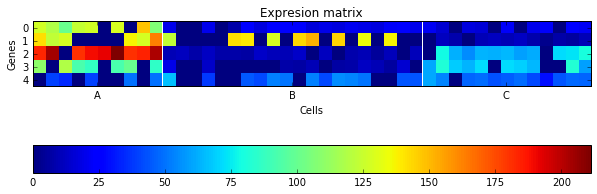

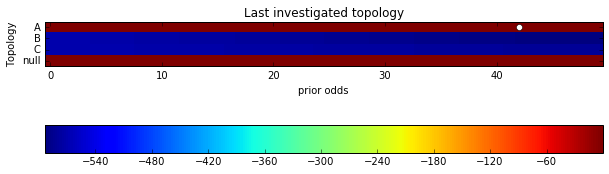

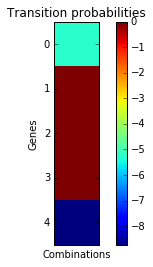

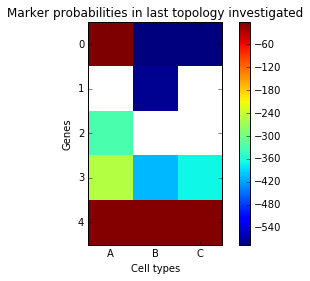

In [178]:
#inputs:
#tfdata --> log-transformed data. rows = genes. columns = replicates (several per cell type). 
#idxs --> which cell types are we interested in out of all of the cell types in tfdata?
#labs --> cell type names
#iunique --> what is the cell type identity of each column of tfdata?
#iunique has same length as the # of columns in tfdata, and the max value
#of iunique is the number of cell types.


obj = topologies_and_genes()


#simulate some data:
#3 cell types A,B,C with 5 genes g1,g2,...,g4
# g1,g2,g3 have clear minimum in B and similar values in A,C and g4 has a clear maximum in A and similar in B,C 
#for T=𝒜 and βi=1, our model is that the distribution of the expression levels of gA,B,Ci
# in the three cell types A, B and C has the smallest mean value in either B or C but not in A

nA = 10 #no. cells of type A
nB = 20 #no. cells of type B
nC = 13 #no. cells of type C
idxs = np.arange(3,dtype=int)
labs = np.array(['A','B','C'])
iunique = np.concatenate([np.ones(nA)*idxs[0],np.ones(nB)*idxs[1],np.ones(nC)*idxs[2]])
iunique = np.array(iunique,dtype=int)

g1_A = obj.simulate_ZIP(mu_true=120, psi_true=0.8, nx=1, ny=nA)
g1_B = obj.simulate_ZIP(mu_true=20, psi_true=0.7, nx=1, ny=nB)
g1_C = obj.simulate_ZIP(mu_true=20, psi_true=0.75, nx=1, ny=nC)
#min in C

g2_A = obj.simulate_ZIP(mu_true=140, psi_true=0.8, nx=1, ny=nA)
g2_B = obj.simulate_ZIP(mu_true=140, psi_true=0.7, nx=1, ny=nB)
g2_C = obj.simulate_ZIP(mu_true=10, psi_true=0.75, nx=1, ny=nC)
#min in C

g3_A = obj.simulate_ZIP(mu_true=190, psi_true=0.8, nx=1, ny=nA)
g3_B = obj.simulate_ZIP(mu_true=10, psi_true=0.7, nx=1, ny=nB)
g3_C = obj.simulate_ZIP(mu_true=70, psi_true=0.75, nx=1, ny=nC)
#min in B

g4_A = obj.simulate_ZIP(mu_true=100, psi_true=0.8, nx=1, ny=nA)
g4_B = obj.simulate_ZIP(mu_true=10, psi_true=0.7, nx=1, ny=nB)
g4_C = obj.simulate_ZIP(mu_true=70, psi_true=0.75, nx=1, ny=nC)
#min in B

g5_A = obj.simulate_ZIP(mu_true=45, psi_true=0.8, nx=1, ny=nA)
g5_B = obj.simulate_ZIP(mu_true=50, psi_true=0.7, nx=1, ny=nB)
g5_C = obj.simulate_ZIP(mu_true=50, psi_true=0.75, nx=1, ny=nC)
#min in A

#plt.hist(np.ravel(g1_A),alpha=0.75)
#plt.hist(np.ravel(g1_B),alpha=0.75)
#plt.hist(np.ravel(g1_C),alpha=0.75)
#plt.show()

tfdata= np.vstack([np.column_stack([g1_A,g1_B,g1_C]),
                   np.column_stack([g2_A,g2_B,g2_C]),
                   np.column_stack([g3_A,g3_B,g3_C]),
                   np.column_stack([g4_A,g4_B,g4_C]),
                   np.column_stack([g5_A,g5_B,g5_C])])


obj.set_data(tfdata, idxs, labs, iunique)

#set the paramters
obj.get_parameters();
#modify the Params to have the right range and distribution type
obj.Params.cutoff = 1#no cutoff
obj.Params.mumax = 250.
obj.Params.mumin = 0.
obj.Params.mbins = 128
obj.Params.sigmin = 0.1
obj.Params.sigmax = 0.9
obj.Params.dist = 'P'
start = time.time()
obj.start_Sibilant()
print('Total time: '+ str(time.time()-start))
#plot last topology prob as a function of prior odds
plt.figure(figsize=(10,7))
for x_line in np.where(np.diff(obj.iunique))[0]:
    plt.plot([x_line+0.5,x_line+0.5],[-1,obj.tfdata.shape[0]+1],'w')
plt.imshow(obj.tfdata,interpolation='nearest')
plt.xticks([np.mean(np.where(obj.iunique==idx_)[0]) for idx_ in obj.idxs],obj.labs)
#plt.yticks([0,1,2,3],['A','B','C','null'])
plt.xlabel('Cells')
plt.ylabel('Genes')
plt.colorbar(orientation='horizontal')
plt.title('Expresion matrix')
plt.show()

#plot last topology prob as a function of prior odds
plt.figure(figsize=(10,7))
plt.title('Last investigated topology')
plt.plot([obj.report_ind],[obj.tlikely_ind],'wo')
plt.imshow(np.log(obj.pT_g).T,interpolation='nearest')
plt.yticks([0,1,2,3],['A','B','C','null'])

plt.xlabel('prior odds')
plt.ylabel('Topology')
plt.colorbar(orientation='horizontal')
plt.show()

#plot transition probabilities
plt.figure()
plt.imshow(np.log(obj.transition_probs),interpolation='nearest')
plt.xticks([],[])
plt.title('Transition probabilities')
plt.ylabel('Genes')
plt.xlabel('Combinations')
plt.colorbar()

plt.figure()
plt.imshow(np.log(obj.marker_probs[:,:,-1]),interpolation='nearest')
plt.xticks([],[])
plt.title('Marker probabilities in last topology investigated')
plt.xlabel('Cell types')
plt.xticks([0,1,2],['A','B','C'])
plt.ylabel('Genes')
plt.colorbar();


In [174]:
np.sum(obj.times3)

23.376501083374023

In [123]:
print(obj.good_transition)
print(obj.good_marker)

[False  True  True  True False]
[ True False False False False]


Sibilant started.
Beginning integration.
0 genes integrated.
Starting trajectories.
Starting gene selection.


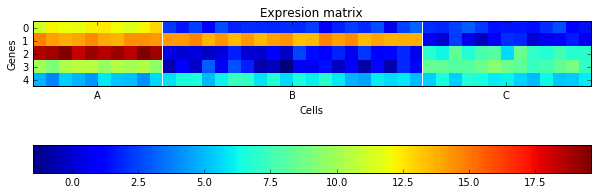

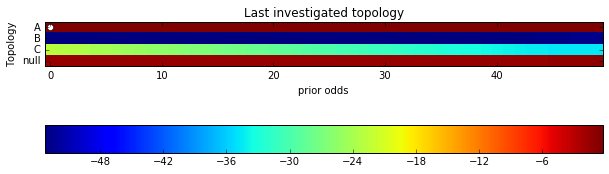

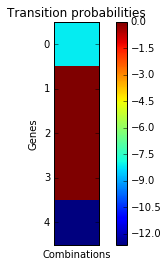

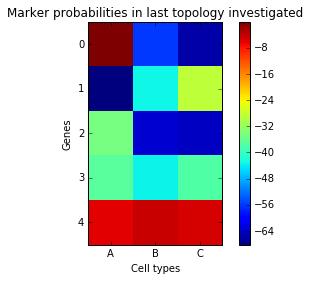

In [118]:
#inputs:
#tfdata --> log-transformed data. rows = genes. columns = replicates (several per cell type). 
#idxs --> which cell types are we interested in out of all of the cell types in tfdata?
#labs --> cell type names
#iunique --> what is the cell type identity of each column of tfdata?
#iunique has same length as the # of columns in tfdata, and the max value
#of iunique is the number of cell types.


obj = topologies_and_genes()


#simulate some data:
#3 cell types A,B,C with 5 genes g1,g2,...,g4
# g1,g2,g3 have clear minimum in B and similar values in A,C and g4 has a clear maximum in A and similar in B,C 
#for T=𝒜 and βi=1, our model is that the distribution of the expression levels of gA,B,Ci
# in the three cell types A, B and C has the smallest mean value in either B or C but not in A

nA = 10 #no. cells of type A
nB = 20 #no. cells of type B
nC = 13 #no. cells of type C
idxs = np.arange(3,dtype=int)
labs = np.array(['A','B','C'])
iunique = np.concatenate([np.ones(nA)*idxs[0],np.ones(nB)*idxs[1],np.ones(nC)*idxs[2]])
iunique = np.array(iunique,dtype=int)

g1_A = obj.simulate_ZIP(mu_true=12, psi_true=5, nx=1, ny=nA, dist='N')
g1_B = obj.simulate_ZIP(mu_true=2, psi_true=2, nx=1, ny=nB, dist='N')
g1_C = obj.simulate_ZIP(mu_true=2, psi_true=2.5, nx=1, ny=nC, dist='N')
#min in C

g2_A = obj.simulate_ZIP(mu_true=14, psi_true=4, nx=1, ny=nA, dist='N')
g2_B = obj.simulate_ZIP(mu_true=14, psi_true=5, nx=1, ny=nB, dist='N')
g2_C = obj.simulate_ZIP(mu_true=1, psi_true=1.5, nx=1, ny=nC, dist='N')
#min in C

g3_A = obj.simulate_ZIP(mu_true=19, psi_true=6, nx=1, ny=nA, dist='N')
g3_B = obj.simulate_ZIP(mu_true=1, psi_true=1.5, nx=1, ny=nB, dist='N')
g3_C = obj.simulate_ZIP(mu_true=7, psi_true=2.5, nx=1, ny=nC, dist='N')
#min in B

g4_A = obj.simulate_ZIP(mu_true=10, psi_true=3, nx=1, ny=nA, dist='N')
g4_B = obj.simulate_ZIP(mu_true=1, psi_true=1.5, nx=1, ny=nB, dist='N')
g4_C = obj.simulate_ZIP(mu_true=8, psi_true=2.5, nx=1, ny=nC, dist='N')
#min in B

g5_A = obj.simulate_ZIP(mu_true=5, psi_true=3, nx=1, ny=nA, dist='N')
g5_B = obj.simulate_ZIP(mu_true=6, psi_true=3, nx=1, ny=nB, dist='N')
g5_C = obj.simulate_ZIP(mu_true=6, psi_true=2.5, nx=1, ny=nC, dist='N')
#min in A

#plt.hist(np.ravel(g1_A),alpha=0.75)
#plt.hist(np.ravel(g1_B),alpha=0.75)
#plt.hist(np.ravel(g1_C),alpha=0.75)
#plt.show()

tfdata= np.vstack([np.column_stack([g1_A,g1_B,g1_C]),
                   np.column_stack([g2_A,g2_B,g2_C]),
                   np.column_stack([g3_A,g3_B,g3_C]),
                   np.column_stack([g4_A,g4_B,g4_C]),
                   np.column_stack([g5_A,g5_B,g5_C])])


obj.set_data(tfdata, idxs, labs, iunique)

#set the paramters
obj.get_parameters();
#modify the Params to have the right range and distribution type
obj.Params.cutoff = 0.#no cutoff
obj.Params.mumax = 25.
obj.Params.mumin = 0.
obj.Params.sigmin = 0.
obj.Params.sigmax = 10.
obj.Params.dist = 'N'

obj.start_Sibilant()

#plot last topology prob as a function of prior odds
plt.figure(figsize=(10,7))
for x_line in np.where(np.diff(obj.iunique))[0]:
    plt.plot([x_line+0.5,x_line+0.5],[-1,obj.tfdata.shape[0]+1],'w')
plt.imshow(obj.tfdata,interpolation='nearest')
plt.xticks([np.mean(np.where(obj.iunique==idx_)[0]) for idx_ in obj.idxs],obj.labs)
#plt.yticks([0,1,2,3],['A','B','C','null'])
plt.xlabel('Cells')
plt.ylabel('Genes')
plt.colorbar(orientation='horizontal')
plt.title('Expresion matrix')
plt.show()

#plot last topology prob as a function of prior odds
plt.figure(figsize=(10,7))
plt.title('Last investigated topology')
plt.plot([obj.report_ind],[obj.tlikely_ind],'wo')
plt.imshow(np.log(obj.pT_g).T,interpolation='nearest')
plt.yticks([0,1,2,3],['A','B','C','null'])

plt.xlabel('prior odds')
plt.ylabel('Topology')
plt.colorbar(orientation='horizontal')
plt.show()

#plot transition probabilities
plt.figure()
plt.imshow(np.log(obj.transition_probs),interpolation='nearest')
plt.xticks([],[])
plt.title('Transition probabilities')
plt.ylabel('Genes')
plt.xlabel('Combinations')
plt.colorbar()

plt.figure()
plt.imshow(np.log(obj.marker_probs[:,:,-1]),interpolation='nearest')
plt.xticks([],[])
plt.title('Marker probabilities in last topology investigated')
plt.xlabel('Cell types')
plt.xticks([0,1,2],['A','B','C'])
plt.ylabel('Genes')
plt.colorbar();

In [119]:
print(obj.good_transition)
print(obj.good_marker)

[False  True  True  True False]
[ True False False False False]


In [100]:
obj.good_genes

array([ True,  True,  True,  True, False], dtype=bool)

In [109]:
obj.transition_probs

array([[  3.02078138e-04],
       [  1.00000000e+00],
       [  1.00000000e+00],
       [  1.00000000e+00],
       [  2.67619294e-04]])

In [110]:
obj.marker_probs[:,:,-1]

array([[  9.99745859e-01,   8.20424189e-25,   2.74368752e-29],
       [  6.77223475e-30,   7.24647420e-17,   1.05819951e-13],
       [  9.04848550e-16,   6.32277447e-29,   1.28958178e-28],
       [  3.36388475e-19,   6.58449276e-23,   2.86030987e-18],
       [  1.02053080e-03,   3.24059086e-01,   8.03660804e-03]])

In [129]:
import pandas as pd
tfdata = pd.read_table('./zf6s.ultramini/tfdata.txt',header=None)
labs = pd.read_table('./zf6s.ultramini/labs.txt',header=None)
cells = pd.read_table('./zf6s.ultramini/cells.txt',header=None)
genes = pd.read_table('./zf6s.ultramini/genes.txt',header=None)
iunique = pd.read_table('./zf6s.ultramini/iunique.txt',header=None)
idxs = pd.read_table('./zf6s.ultramini/idxs.txt',header=None)

In [130]:
labs_mini = np.array(labs.iloc[:,0])-1
iunique_mini = np.array(iunique.iloc[:,0])-1
idxs_mini = np.array(idxs.iloc[:,0])-1

In [131]:
tfdata.columns = np.array(cells.iloc[:,0])
tfdata.index = np.array(genes.iloc[:,0])
tfdata

,ZF6S_WT_DS5_AAAACCACATGT,ZF6S_WT_DS5_AAAATCTTACGA,ZF6S_WT_DS5_AAAATTGTCCGA,ZF6S_WT_DS5_AAAATTTCAAAC,ZF6S_WT_DS5_AAACATTGACTC,ZF6S_WT_DS5_AAACCAGGTAGN,ZF6S_WT_DS5_AAACCATCGTGA,ZF6S_WT_DS5_AAACCCCAACGC,ZF6S_WT_DS5_AAACCTTCTTAC,ZF6S_WT_DS5_AAAGAATAGATG,...,ZF6S_WT_DS5b_TTGAATGGGCGC,ZF6S_WT_DS5b_TTGATCCCTTTG,ZF6S_WT_DS5b_TTTAAAGACGCC,ZF6S_WT_DS5b_TTTACGATACAT,ZF6S_WT_DS5b_TTTAGCTACGTC,ZF6S_WT_DS5b_TTTATGAACTGT,ZF6S_WT_DS5b_TTTCGGGTTCAA,ZF6S_WT_DS5b_TTTCTGGCCCGA,ZF6S_WT_DS5b_TTTGCTGCGACG,ZF6S_WT_DS5b_TTTTGAGCGTCC
TAL1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.7992,4.9094,0.0000,0.0000,...,3.9292,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,3.4721
NKX2.5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ACTC1A,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.4904,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ADIPOR1B,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.000,1.9216,0.0000,0.0000,0.0000,0.0000,0.0000
BRD2A,2.3338,0.1125,0.1125,0.1125,0.1125,0.1125,0.1125,1.9899,0.1125,0.1125,...,1.4260,1.7154,2.1202,0.000,0.0000,0.0000,0.0000,2.7861,0.0000,0.0000
ATF4B,0.0575,0.0575,0.0575,0.0575,0.0575,0.0575,0.0575,0.0575,4.2767,0.0575,...,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,2.4577,0.0000,0.0000,0.0000
BAZ1B,2.2382,0.1505,4.3849,3.4989,0.1505,3.6874,0.1505,1.9149,0.1505,0.1505,...,0.0000,0.0000,3.0511,4.742,1.5900,2.2252,3.1711,0.0000,0.0000,2.6031
GATA2A,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.3998,1.6678,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
PAX2A,0.0000,0.0000,0.0000,3.4366,0.0000,0.0000,0.0000,1.8160,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
HAND2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.9400,...,0.0000,0.0000,0.0000,0.000,4.5179,0.0000,2.8245,0.0000,0.0000,0.0000


In [132]:
iunique_st = iunique_mini[np.argsort(iunique_mini)]
tfdata_st = tfdata.iloc[:,np.argsort(iunique_mini)]

In [133]:
tfdata_st

,ZF6S_WT_DS5_AAAACCACATGT,ZF6S_WT_DS5_GATGAGACTCTA,ZF6S_WT_DS5b_TGGCTGCTTCAT,ZF6S_WT_DS5b_GCCGTCGCCGAT,ZF6S_WT_DS5b_GCCATTCAAATG,ZF6S_WT_DS5b_GCCACGGACGCT,ZF6S_WT_DS5b_TGGTCGGACCCG,ZF6S_WT_DS5b_GCACTGGAGACN,ZF6S_WT_DS5b_TGGTTGCAAACC,ZF6S_WT_DS5b_GATCTGCCGTGC,...,ZF6S_WT_DS5_CGAGTTAGTTAG,ZF6S_WT_DS5b_CTTACATGGCAT,ZF6S_WT_DS5b_TCCTATCCGCGC,ZF6S_WT_DS5b_GGCTGTTTTAAN,ZF6S_WT_DS5b_AGCCTTATATAT,ZF6S_WT_DS5_AGTGTAGTAATA,ZF6S_WT_DS5_GAGCCTATCTCC,ZF6S_WT_DS5_GACACACCCGCA,ZF6S_WT_DS5_TGAAACATGATC,ZF6S_WT_DS5b_TCCGCGGCAGGC
TAL1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
NKX2.5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ACTC1A,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ADIPOR1B,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
BRD2A,2.3338,0.1125,1.1863,0.0000,0.0000,0.0000,2.8800,2.6265,0.0000,0.0000,...,0.1125,0.0000,0,0.0000,2.1482,0.1125,0.1125,0.1125,0.1125,0.0000
ATF4B,0.0575,0.0575,0.0000,0.0000,0.0000,1.8964,0.0000,0.0000,0.0000,1.8541,...,0.0575,0.0000,0,1.7281,1.6179,0.0575,0.0575,0.0575,0.0575,0.0000
BAZ1B,2.2382,0.1505,1.2086,1.7707,0.0000,1.0949,3.5364,1.9245,3.0927,3.0098,...,0.1505,3.1711,0,0.0000,0.0000,0.1505,3.0215,0.1505,0.1505,2.3036
GATA2A,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0114,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
PAX2A,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
HAND2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<IPython.core.display.Javascript object>


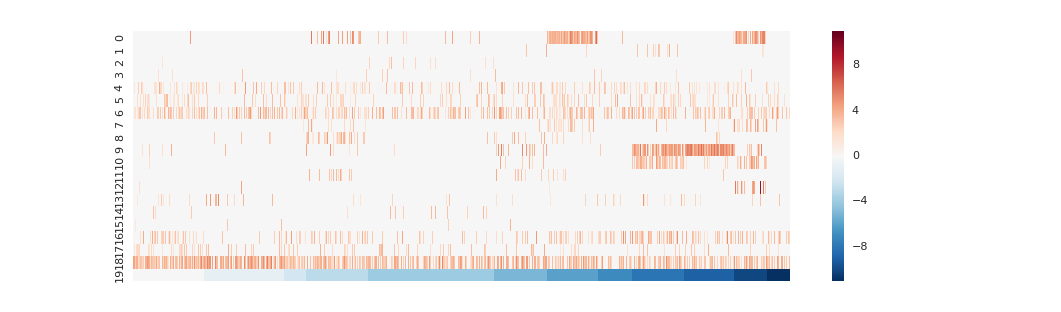

In [255]:
import seaborn as sns
%matplotlib notebook
sns.heatmap(np.vstack([tfdata_st,-iunique_st]),xticklabels=False)

In [ ]:
%matplotlib inline

In [136]:
#inputs:
#tfdata --> log-transformed data. rows = genes. columns = replicates (several per cell type). 
#idxs --> which cell types are we interested in out of all of the cell types in tfdata?
#labs --> cell type names
#iunique --> what is the cell type identity of each column of tfdata?
#iunique has same length as the # of columns in tfdata, and the max value
#of iunique is the number of cell types.

obj = topologies_and_genes()

#simulate some data:
#3 cell types A,B,C with 5 genes g1,g2,...,g4
# g1,g2,g3 have clear minimum in B and similar values in A,C and g4 has a clear maximum in A and similar in B,C 
#for T=𝒜 and βi=1, our model is that the distribution of the expression levels of gA,B,Ci
# in the three cell types A, B and C has the smallest mean value in either B or C but not in A

idxs = idxs_mini
labs = labs_mini
iunique = np.array(iunique_st,dtype=int)
tfdata = np.array(tfdata_st)
tfdata = 2**tfdata - 1

obj.set_data(tfdata, idxs, labs, iunique)

#set the paramters
obj.get_parameters();
#modify the Params to have the right range and distribution type
obj.Params.cutoff = 0.#no cutoff
obj.Params.mumax = 650.
obj.Params.mumin = 0.
obj.Params.sigmin = 0.
obj.Params.sigmax = .6
obj.Params.dist = 'P'
obj.Params.plikely_thresh = 0.6; # threshold for probability of topology given data
obj.Params.mbins = 650; #number of bins for numeric integration over distribution parameters
obj.Params.sbins = 15;
        
obj.start_Sibilant()

Sibilant started.
Beginning integration.
0 genes integrated.
Starting trajectories.
Starting gene selection.


<IPython.core.display.Javascript object>


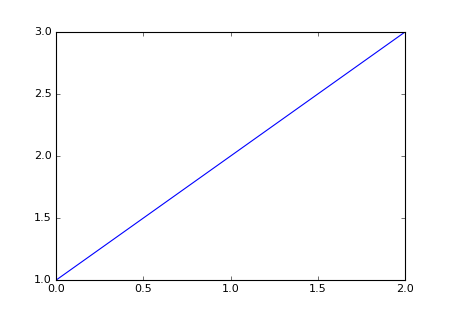

In [259]:
import importlib
import seaborn.apionly as sns
importlib.reload(plt)
importlib.reload(sns)

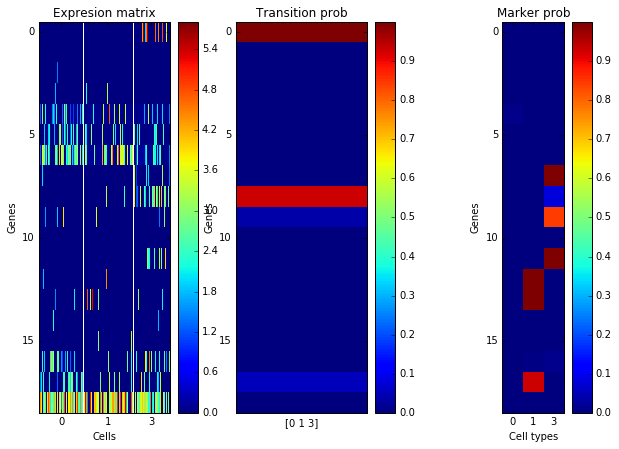

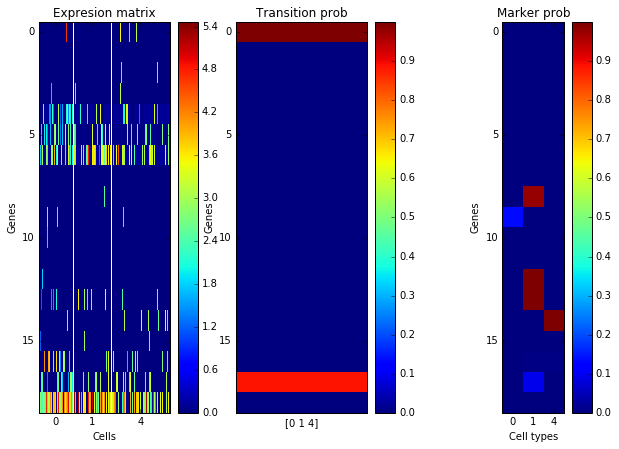

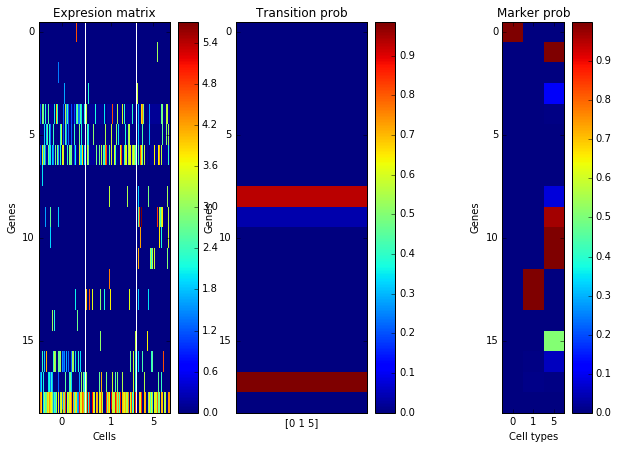

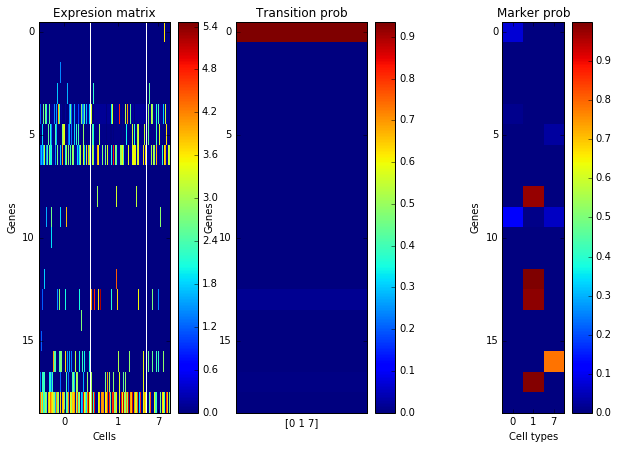

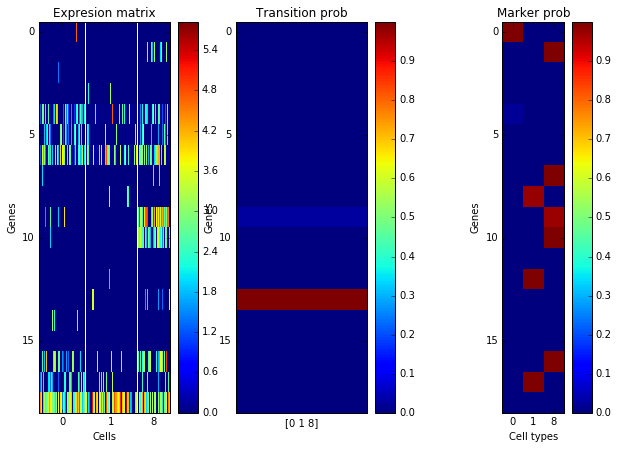

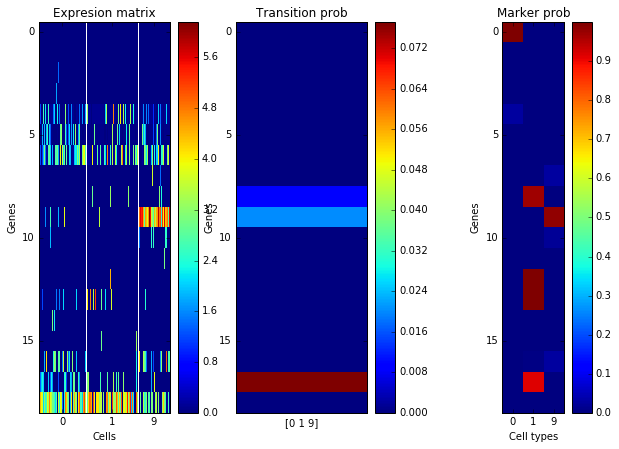

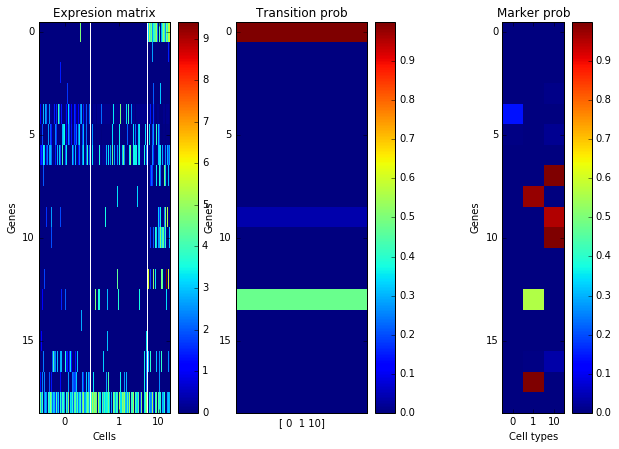

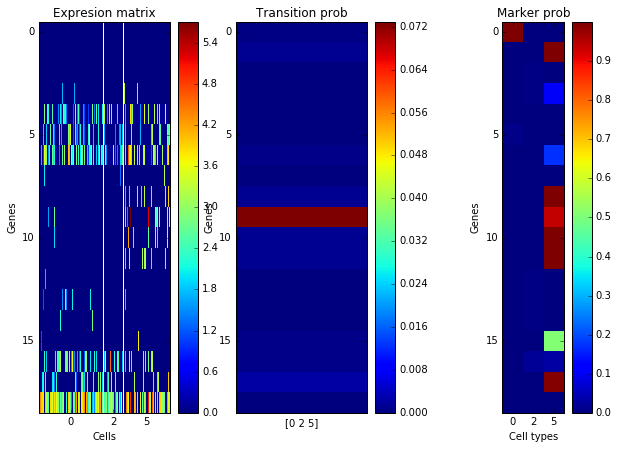

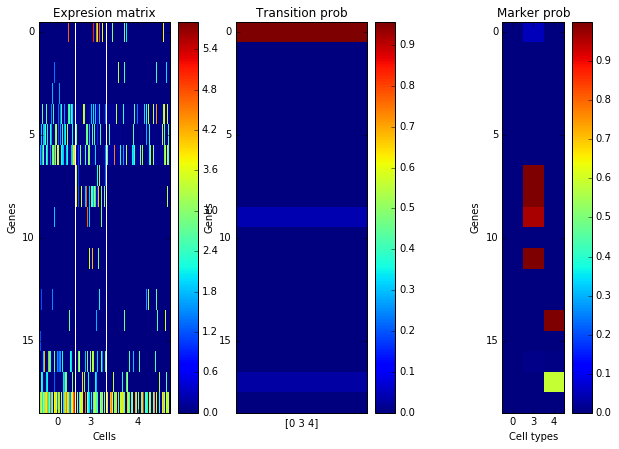

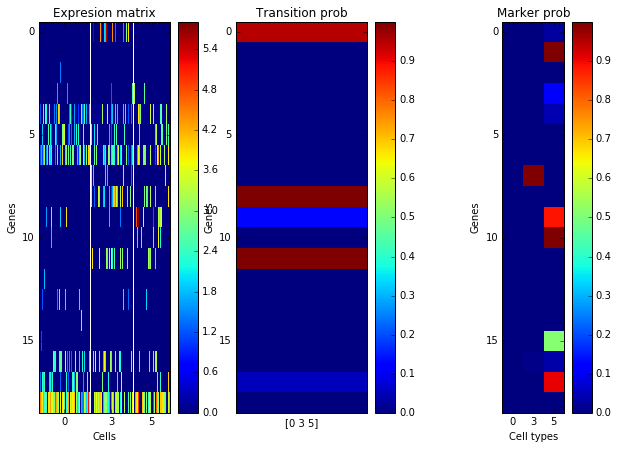

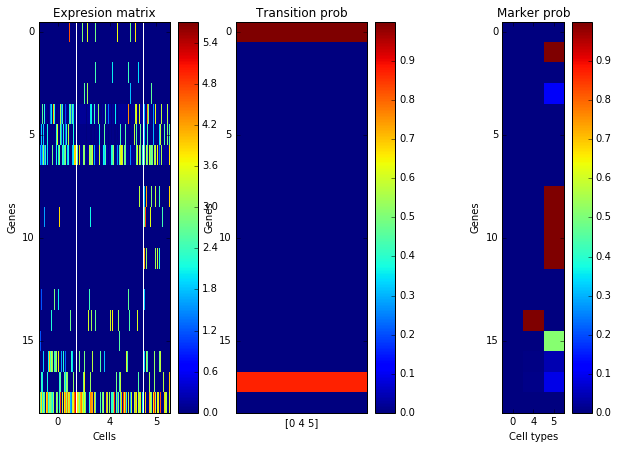

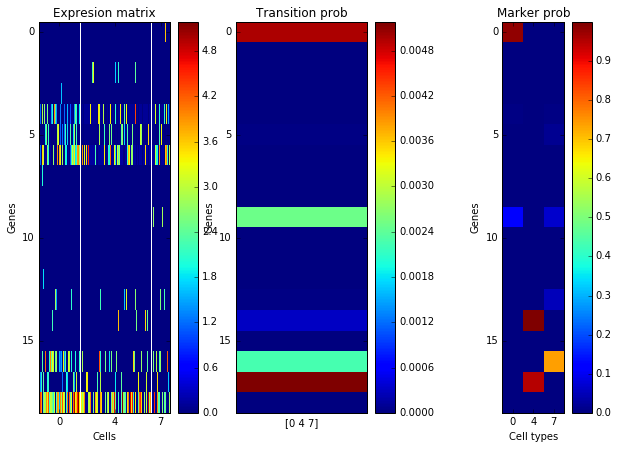

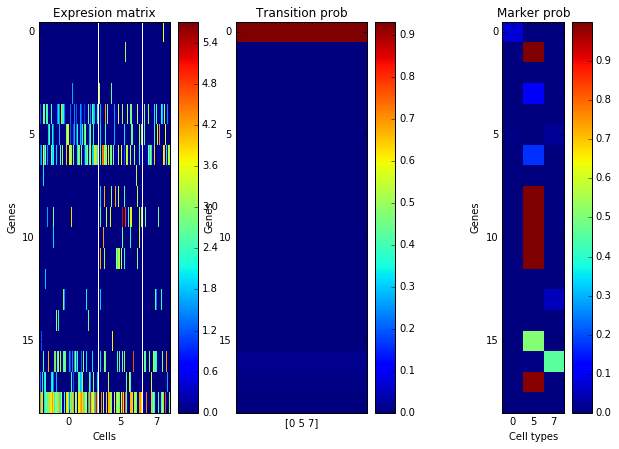

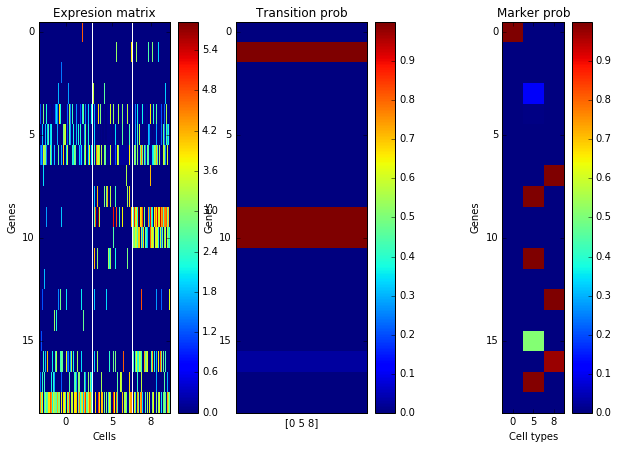

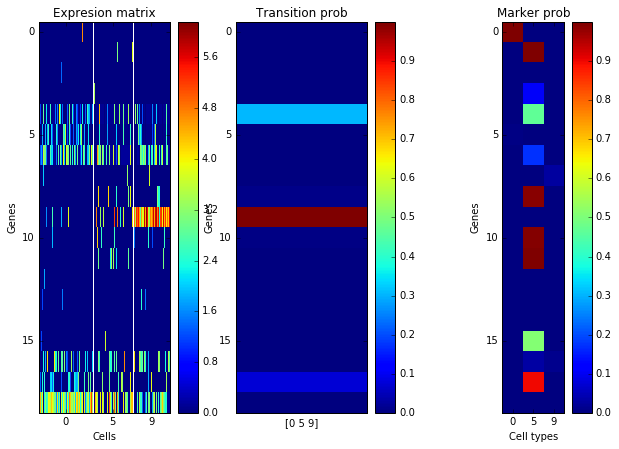

In [138]:
num_pic=0
for i in range(len(obj.combinations)):
    if (np.max(obj.transition_probs[:,i])>0 or np.max(obj.marker_probs[:,:,i])>0) and num_pic < 15:
        num_pic+=1
        iii = obj.combinations[i,:]
        plt.figure(figsize=(10,7))
        plt.subplot(1,3,1)
        ind123 = np.sum([iunique==idx_ for idx_ in idxs[iii]],axis=0)>0
        ind123 = np.where(ind123)[0]
        for x_line in np.where(np.diff(obj.iunique[ind123]))[0]:
            plt.plot([x_line+0.5,x_line+0.5],[-1,obj.tfdata[:,ind123].shape[0]+1],'w')
        plt.imshow(np.log2(obj.tfdata[:,ind123]+1),interpolation='nearest',aspect='auto')
        plt.xticks([np.mean(np.where(obj.iunique[ind123]==idx_)[0]) for idx_ in iii],obj.labs[iii])
        plt.xlabel('Cells')
        plt.ylabel('Genes')
        plt.colorbar(orientation='vertical')
        plt.title('Expresion matrix')

        #plot transition probabilities
        plt.subplot(132)
        #plt.imshow(np.log(np.reshape(obj.transition_probs[:,i],(19,1))),interpolation='nearest',aspect='auto')
        plt.imshow(np.reshape(obj.transition_probs[:,i],(19,1)),interpolation='nearest',aspect='auto')
        plt.xticks([],[])
        plt.title('Transition prob')
        plt.ylabel('Genes')
        plt.xlabel(iii)
        plt.colorbar()

        plt.subplot(133)
        #plt.imshow(np.log(obj.marker_probs[:,:,i]),interpolation='nearest')
        plt.imshow(obj.marker_probs[:,:,i],interpolation='nearest')
        plt.title('Marker prob')
        plt.xlabel('Cell types')
        plt.xticks([0,1,2],iii)
        plt.ylabel('Genes')
        plt.colorbar();

In [139]:
print(obj.good_transition)
print(obj.good_marker)

[ True  True False False False False  True  True  True  True  True  True
 False  True False False False  True  True]
[ True  True False False  True False  True  True  True  True  True  True
  True  True  True False  True  True  True]
